## Import packages

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

## Load data

In [3]:
WRK_DIR = '/home/boo/Documents/Personal/Projects/ImageResolution/'
PATH = os.path.join(WRK_DIR, 'Data_224')

The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat_0.jpg, cat_1.jpg, cat_2.jpg ....]
    |______ <b>dogs</b>: [dog_0.jpg, dog_1.jpg, dog_2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat_2000.jpg, cat_2001.jpg, cat_2002.jpg ....]
    |______ <b>dogs</b>: [dog_2000.jpg, dog_2001.jpg, dog_2002.jpg ...]
</pre>

After extracting its contents, assign variables with the proper file path for the training and validation set.

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understand the data

Let's look at how many cats and dogs images are in the training and validation directory:

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 2449
total training dog images: 2397
total validation cat images: 288
total validation dog images: 282
--
Total training images: 4846
Total validation images: 570


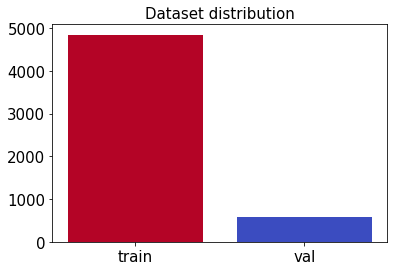

In [8]:
x = ['train', 'val']
data = [total_train, total_val]
fig, ax = plt.subplots(1, 1)
 
# Get a color map
my_cmap = cm.get_cmap('coolwarm')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=min(data), vmax=max(data))
 
ax.bar(x, data, color=my_cmap(my_norm(data)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('Frequency',fontsize=15)

plt.title('Dataset distribution',fontsize=15)
plt.show()

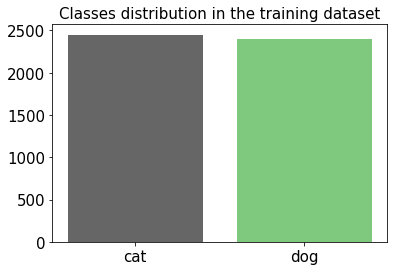

In [9]:
x = ['cat', 'dog']
data = [num_cats_tr, num_dogs_tr]
fig, ax = plt.subplots(1, 1)
 
# Get a color map
my_cmap = cm.get_cmap('Accent')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=min(data), vmax=max(data))
 
ax.bar(x, data, color=my_cmap(my_norm(data)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('Frequency',fontsize=15)

plt.title('Classes distribution in the training dataset',fontsize=15)
plt.show()

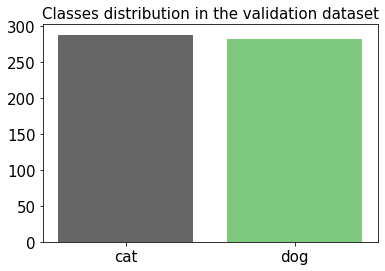

In [10]:
x = ['cat', 'dog']
data = [num_cats_val, num_dogs_val]
fig, ax = plt.subplots(1, 1)
 
# Get a color map
my_cmap = cm.get_cmap('Accent')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=min(data), vmax=max(data))
 
ax.bar(x, data, color=my_cmap(my_norm(data)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('Frequency',fontsize=15)

plt.title('Classes distribution in the validation dataset',fontsize=15)
plt.show()

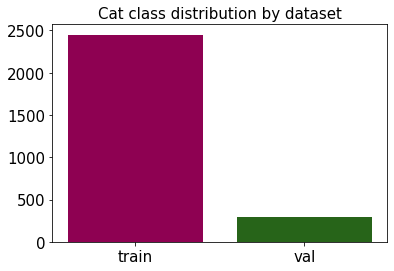

In [11]:
x = ['train', 'val']
data = [num_cats_tr, num_cats_val]
fig, ax = plt.subplots(1, 1)
 
# Get a color map
my_cmap = cm.get_cmap('PiYG_r')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=min(data), vmax=max(data))
 
ax.bar(x, data, color=my_cmap(my_norm(data)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('Frequency',fontsize=15)

plt.title('Cat class distribution by dataset',fontsize=15)
plt.show()

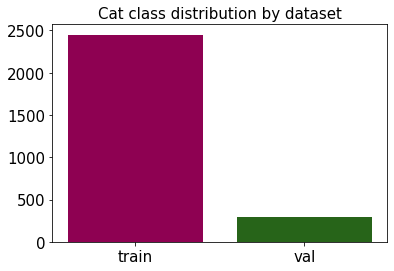

In [12]:
x = ['train', 'val']
data = [num_cats_tr, num_cats_val]
fig, ax = plt.subplots(1, 1)
 
# Get a color map
my_cmap = cm.get_cmap('PiYG_r')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=min(data), vmax=max(data))
 
ax.bar(x, data, color=my_cmap(my_norm(data)))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('Frequency',fontsize=15)

plt.title('Cat class distribution by dataset',fontsize=15)
plt.show()

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [13]:
batch_size = 55
epochs = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 4845 images belonging to 2 classes.


In [16]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 569 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [17]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [18]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

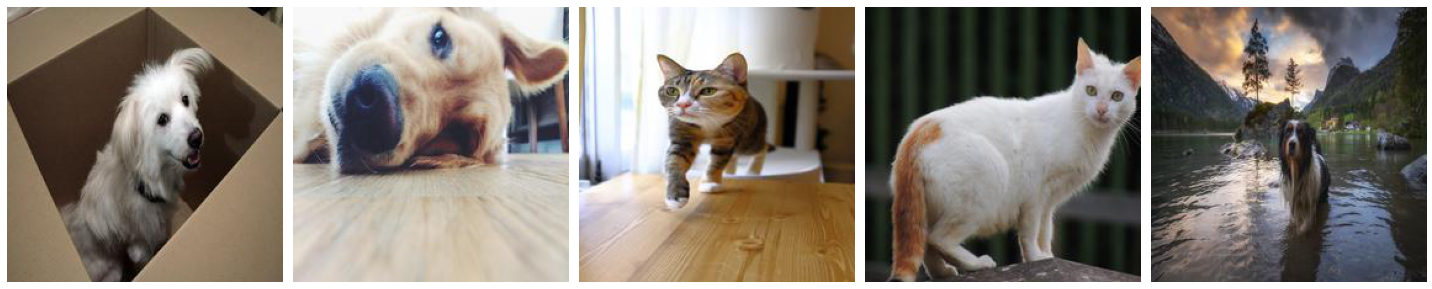

In [19]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [20]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

For this tutorial, choose the *ADAM* optimizer and *binary cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [23]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 10 steps
Epoch 1/4
88/88 [==============================] - 98s 1s/step - loss: 0.7688 - accuracy: 0.5077 - val_loss: 0.6778 - val_accuracy: 0.5873
Epoch 2/4
88/88 [==============================] - 99s 1s/step - loss: 0.6383 - accuracy: 0.5797 - val_loss: 0.6332 - val_accuracy: 0.5418
Epoch 3/4
88/88 [==============================] - 109s 1s/step - loss: 0.5570 - accuracy: 0.6785 - val_loss: 0.5565 - val_accuracy: 0.7000
Epoch 4/4
88/88 [==============================] - 110s 1s/step - loss: 0.4813 - accuracy: 0.7501 - val_loss: 0.5527 - val_accuracy: 0.6764


### Visualize training results

Now visualize the results after training the network.

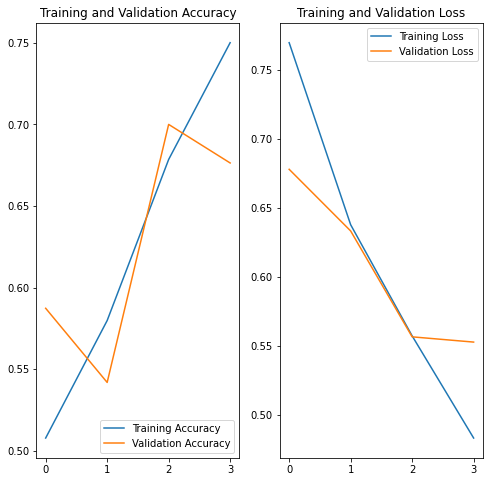

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

## Data augmentation

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [26]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 4845 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [27]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

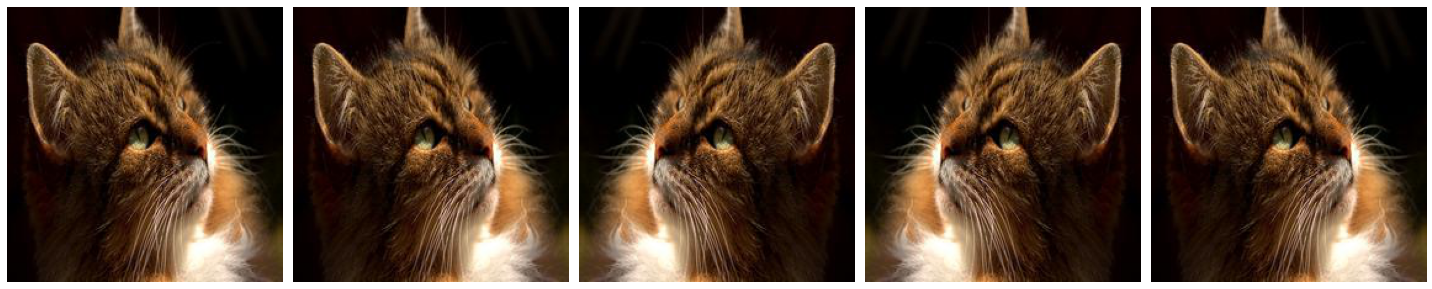

In [28]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Let's take a look at a different augmentation called rotation and apply 45 degrees of rotation randomly to the training examples.

In [29]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [30]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 4845 images belonging to 2 classes.


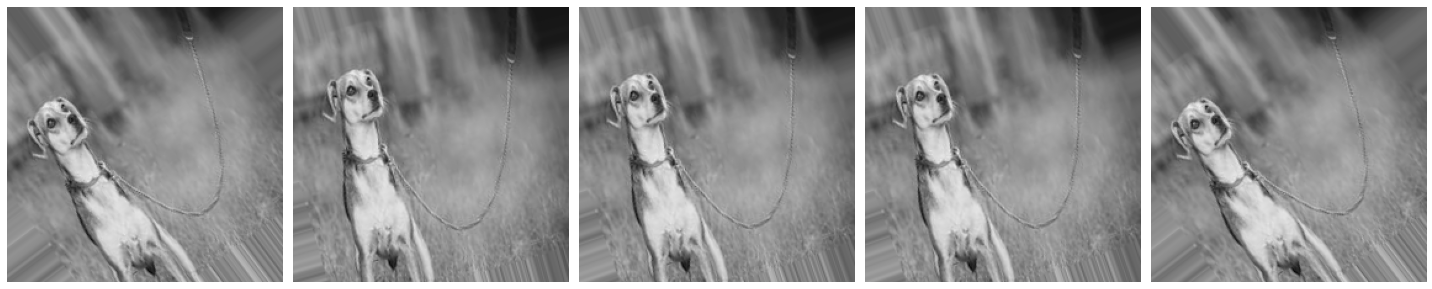

In [31]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [32]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [33]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 4845 images belonging to 2 classes.


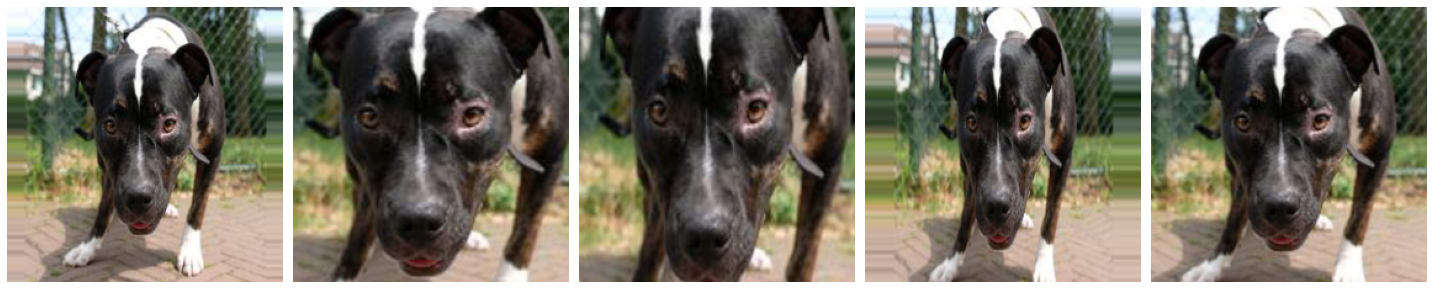

In [34]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations. Here, you applied rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [35]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [36]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 4845 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

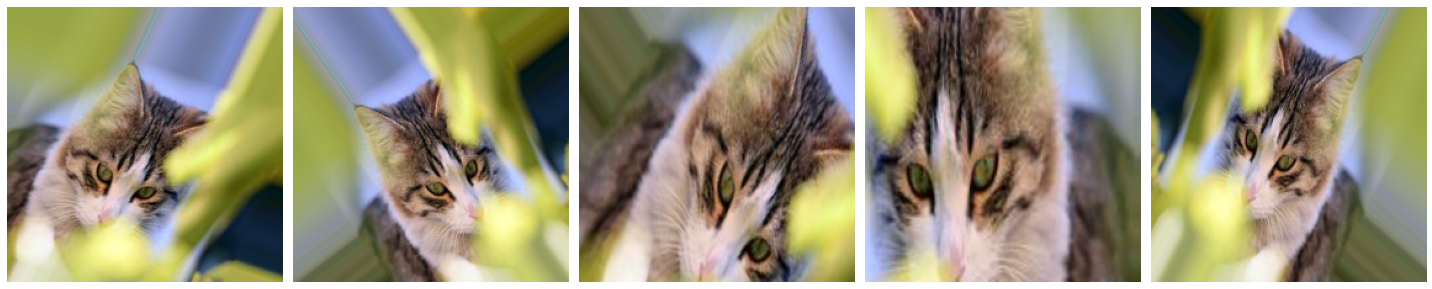

In [37]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [38]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [39]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 569 images belonging to 2 classes.


## Dropout

## Creating a new network with Dropouts

Here, you apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset.

In [40]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [41]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)       

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [42]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 10 steps
Epoch 1/4
88/88 [==============================] - 124s 1s/step - loss: 0.9253 - accuracy: 0.5056 - val_loss: 0.6863 - val_accuracy: 0.5036
Epoch 2/4
88/88 [==============================] - 126s 1s/step - loss: 0.6846 - accuracy: 0.5081 - val_loss: 0.6783 - val_accuracy: 0.5036
Epoch 3/4
88/88 [==============================] - 148s 2s/step - loss: 0.6770 - accuracy: 0.5171 - val_loss: 0.6702 - val_accuracy: 0.5036
Epoch 4/4
88/88 [==============================] - 160s 2s/step - loss: 0.6718 - accuracy: 0.5294 - val_loss: 0.6679 - val_accuracy: 0.5036


### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

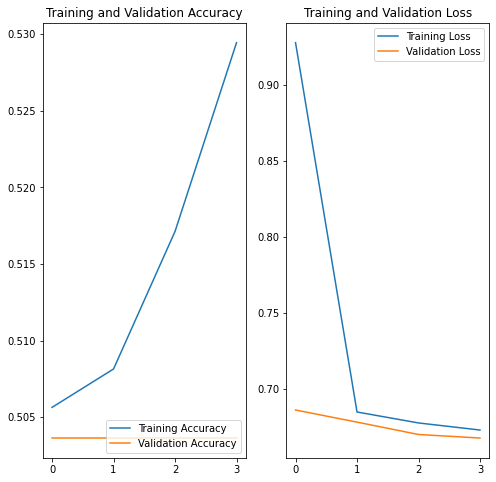

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()